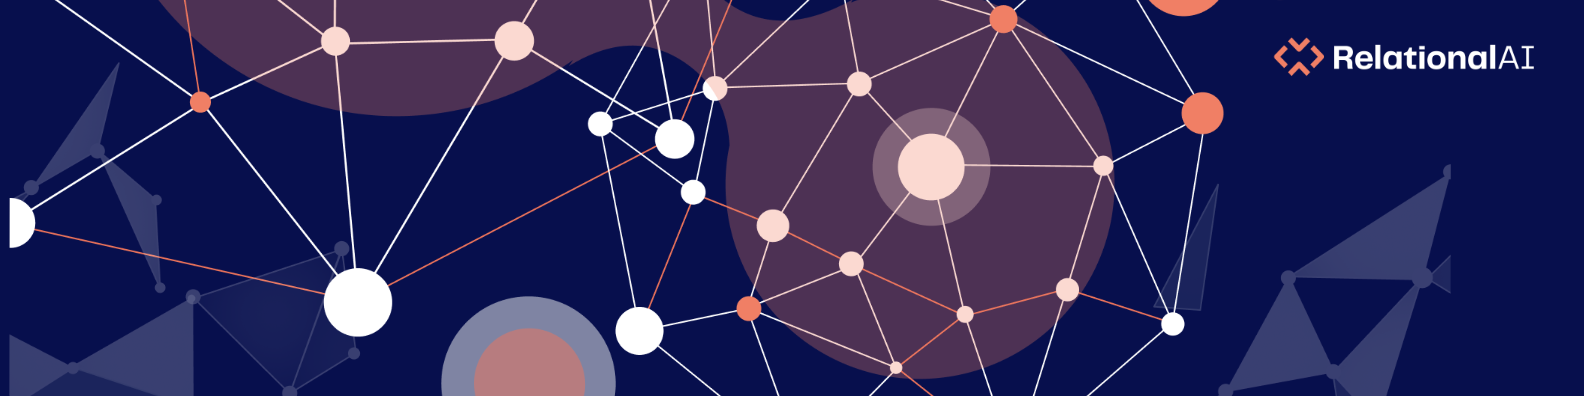

# Track and Trace

## Overview
In this demo, we will show how the log data about different product items being scanned at various locations can be loaded into RelationalAI knowledge graph in order to be able to track and trace a specific item, as well as a number of items, matching certain characteristics (for example, being produced at location A within a period of time X), and tell what's the current location of the item(s) and how it/they got there.

Additionally, we will take into account the fact that some items are created by transforming or aggregating other item or items, so their complete journey consists of more than just the events referencing them directly, but might have more steps before, as well as after, being recorded under a different tracking number.
In production and supply business, this functionality is often useful when for some reason there is a need to recall all the items originating at some factory, where something went wrong at a certain point in time, especially if it provides some raw materials, which are then could be used to produce multiple different types of products and sent to many different locations.
***

## Let's get started!
### Importing Packages 
We start by installing and importing all the Python packages and modules that we will need, including the `relationalai` package. We then define the `TrackAndTrace` model object.

In [ ]:
import sys

def install_packages():
    in_snowflake_notebook = "snowbook" in sys.modules
    if in_snowflake_notebook:
        sys.path.append("./relationalai.zip")
        print("Install matplotlib from package dropdown.")
    else:
        import os
        os.system('pip install relationalai matplotlib')

install_packages()

> **Note**. Models represent collections of objects. Objects, like Python objects, have types and properties, which we will define in a bit.

In [2]:
import relationalai as rai
from relationalai.std import alias, aggregates, rel, Vars
from relationalai.std.dates import milliseconds
from relationalai.std.graphs import Graph
import matplotlib as mpl
from typing import Tuple
from datetime import datetime
import pandas as pd

provider = rai.Provider()

Connecting to ws://0.0.0.0:8080/ws/program...
Failed to connect to ws://0.0.0.0:8080/ws/program. Running with debug sink disabled.


In [ ]:
provider.sql("""
create database if not exists RAI_DEMO;
create schema if not exists RAI_DEMO.TRACK_TRACE;

create or replace table RAI_DEMO.TRACK_TRACE.ITEMS (
    ID NUMBER(38,0) NOT NULL PRIMARY KEY,
    PRODUCT_NAME VARCHAR(255),
    DESCRIPTION VARCHAR(255),
    SERIAL_NUMBER VARCHAR(20)
);
create or replace table RAI_DEMO.TRACK_TRACE.SCANNING_EVENTS (
	ID NUMBER(38,0) NOT NULL PRIMARY KEY,
    ACTION VARCHAR(255),
    TIMESTAMP DATETIME,
    LOCATION VARCHAR(255)
);
create or replace table RAI_DEMO.TRACK_TRACE.EVENT_ITEMS (
    EVENT_ID NUMBER(38,0),
    ITEM_ID NUMBER(38,0),
    TYPE VARCHAR(20)
);

insert into RAI_DEMO.TRACK_TRACE.ITEMS (ID, PRODUCT_NAME, DESCRIPTION, SERIAL_NUMBER)
values
(1, 'Raw Potatoes', 'Fresh potatoes', 'RP123456'),
(2, 'Frozen Hashbrowns', 'Packaged hashbrowns', 'FH987654A'),
(3, 'Frozen Hashbrowns', 'Packaged hashbrowns', 'FH987654B'),
(4, 'Packaged Frozen Hashbrowns', 'Hashbrowns in container', 'PFH333444'),
(5, 'Apples', 'Fresh apples', 'AP567890'),
(6, 'Packaged Apples', 'Apples in container', 'PA112233'),
(7, 'Raw Chicken', 'Fresh chicken', 'RC111222'),
(8, 'Frozen Chicken Nuggets', 'Packaged chicken nuggets', 'FCN333444A'),
(9, 'Frozen Chicken Nuggets', 'Packaged chicken nuggets', 'FCN333444B'),
(10, 'Packaged Frozen Chicken Nuggets', 'Chicken Nuggets in container', 'FCN333444'),
(11, 'Vegetables', 'Mixed vegetables', 'VG555666'),
(12, 'Vegetable Pack', 'Packaged vegetables', 'VP777888'),
(13, 'Pasta', 'Uncooked pasta', 'P999000'),
(14, 'Cooked Pasta', 'Ready-to-eat pasta', 'CP112233A'),
(15, 'Cooked Pasta', 'Ready-to-eat pasta', 'CP112233B'),
(16, 'Tomato Sauce', 'Canned tomato sauce', 'TS223344'),
(17, 'Spaghetti Meal', 'Packaged spaghetti meal', 'SM334455A'),
(18, 'Spaghetti Meal', 'Packaged spaghetti meal', 'SM334455B'),
(19, 'Ground Beef', 'Fresh ground beef', 'GB556677'),
(20, 'Cooked Beef Patty', 'Grilled beef patty', 'CB778899A'),
(21, 'Cooked Beef Patty', 'Grilled beef patty', 'CB778899B'),
(22, 'Hamburger Bun', 'Bread for hamburger', 'HB990011'),
(23, 'Packaged Hamburger', 'Hamburger ready to serve', 'PH002233A'),
(24, 'Packaged Hamburger', 'Hamburger ready to serve', 'PH002233B'),
(25, 'Packing Container', 'Plastic container', 'PC111223'),
(26, 'Packing Container', 'Plastic container', 'PC111224'),
(27, 'Packing Container', 'Plastic container', 'PC111222');

insert into RAI_DEMO.TRACK_TRACE.SCANNING_EVENTS (ID, ACTION, TIMESTAMP, LOCATION)
values
(1, 'Observe', '2024-08-10 08:00:00', 'Warehouse A'),
(2, 'Transform', '2024-08-10 09:00:00', 'Processing Plant B'),
(3, 'Aggregate', '2024-08-10 10:00:00', 'Packaging Facility C'),
(4, 'Observe', '2024-08-11 08:00:00', 'Warehouse A'),
(5, 'Aggregate', '2024-08-11 09:00:00', 'Packaging Facility C'),
(6, 'Observe', '2024-08-10 12:00:00', 'Warehouse D'),
(7, 'Transform', '2024-08-10 13:00:00', 'Processing Plant E'),
(8, 'Aggregate', '2024-08-10 14:00:00', 'Packaging Facility F'),
(9, 'Observe', '2024-08-11 09:00:00', 'Warehouse G'),
(10, 'Ship', '2024-08-11 10:00:00', 'Distribution Center H'),
(11, 'Receive', '2024-08-11 12:00:00', 'Retail Store I'),
(12, 'Transform', '2024-08-11 14:00:00', 'Processing Plant J'),
(13, 'Pack', '2024-08-12 08:00:00', 'Packaging Facility K'),
(14, 'Aggregate', '2024-08-12 09:00:00', 'Packaging Facility K'),
(15, 'Transform', '2024-08-12 10:00:00', 'Processing Plant L'),
(16, 'Observe', '2024-08-12 12:00:00', 'Warehouse M'),
(17, 'Ship', '2024-08-12 14:00:00', 'Distribution Center N'),
(18, 'Receive', '2024-08-13 08:00:00', 'Retail Store O'),
(19, 'Observe', '2024-08-13 09:00:00', 'Warehouse P'),
(20, 'Transform', '2024-08-13 10:00:00', 'Processing Plant Q'),
(21, 'Pack', '2024-08-13 12:00:00', 'Packaging Facility R'),
(22, 'Ship', '2024-08-13 14:00:00', 'Distribution Center S'),
(23, 'Receive', '2024-08-13 16:00:00', 'Retail Store T'),
(24, 'Transform', '2024-08-14 08:00:00', 'Processing Plant U'),
(25, 'Aggregate', '2024-08-14 09:00:00', 'Packaging Facility V'),
(26, 'Observe', '2024-08-14 10:00:00', 'Warehouse W'),
(27, 'Pack', '2024-08-14 12:00:00', 'Packaging Facility X'),
(28, 'Ship', '2024-08-14 14:00:00', 'Distribution Center Y'),
(29, 'Receive', '2024-08-14 16:00:00', 'Retail Store Z'),
(30, 'Transform', '2024-08-12 08:00:00', 'Processing Plant A');

insert into RAI_DEMO.TRACK_TRACE.EVENT_ITEMS (EVENT_ID, ITEM_ID, TYPE)
values
(1, 1, 'input'),
(2, 1, 'input'), (2, 2, 'output'), (2, 3, 'output'),
(3, 2, 'input'), (3, 3, 'input'), (3, 27, 'input'), (3, 4, 'output'),
(4, 5, 'input'),
(5, 5, 'input'), (5, 25, 'input'), (5, 6, 'output'),
(6, 7, 'input'),
(7, 7, 'input'), (7, 8, 'output'), (7, 9, 'output'),
(8, 8, 'input'), (8, 9, 'input'), (8, 26, 'input'), (8, 10, 'output'),
(9, 11, 'input'),
(10, 11, 'input'),
(11, 11, 'input'),
(12, 11, 'input'), (12, 12, 'output'),
(14, 14, 'input'), (14, 15, 'input'), (14, 16, 'input'), (14, 17, 'output'), (14, 18, 'output'),
(15, 19, 'input'), (15, 20, 'output'), (15, 21, 'output'),
(16, 22, 'input'),
(17, 22, 'input'),
(18, 22, 'input'),
(19, 20, 'input'), (19, 21, 'input'),
(20, 20, 'input'), (20, 21, 'input'), (20, 22, 'input'), (20, 23, 'output'), (20, 24, 'output'),
(21, 23, 'input'), (21, 24, 'input'),
(22, 23, 'input'), (22, 24, 'input'),
(23, 23, 'input'), (23, 24, 'input'),
(26, 4, 'input'),(26, 6, 'input'),(26, 10, 'input'),
(27, 4, 'input'),(27, 6, 'input'),(27, 10, 'input'),
(28, 4, 'input'),(28, 6, 'input'),(28, 10, 'input'),
(29, 4, 'input'),(29, 6, 'input'),(29, 10, 'input'),
(30, 13, 'input'),(30, 14, 'output'),(30, 15, 'output');
""")

### Importing the Data

Let's now import the data about items and events happening to them at different locations.

> **Note**. We access data in Snowflake by simply referring to the source: **<my_database.my_schema.my_table>**. `Item`, for instance, contains the data in a database called `rai_demo`, schema `track_trace` and table `items`. 

In [ ]:
model = rai.Model("TrackAndTrace", ensure_change_tracking=True)

# Contains details about the items
Item = model.Type("Item", source = "rai_demo.track_trace.items")

# Contains details about the events
Event = model.Type("Event", source = "rai_demo.track_trace.scanning_events")

# Contains the links between items and events (multiple items can be involved in a single event)
EventItem = model.Type("EventItem", source = "rai_demo.track_trace.event_items")

# Add a items property matching on the id in Event table and the event_id in EventItem table
# as well as a detail property matching on the item_id in EventItem table and the id in Item table
Event.items.has_many()
Event.define(items = (EventItem, 'id', 'event_id'))
EventItem.define(detail = (Item, 'item_id', 'id'))

> **Note**. We connect to Snowflake and create a Snowpark session using the `rai init` command. A `data stream` between the tables under `track_trace` and the `TrackAndTrace` model was created to stream the data from Snowflake to the RAI schema. 

### Getting to know the input data
Let's query our events and associated items to better understand what they describe.

First, we check what are all the properties our `Event`, `Item` and `EventItem` objects have using `known_properties()` function.

In [4]:
print(f"Event properties: {Event.known_properties()}")
print(f"EventItem properties: {EventItem.known_properties()}")
print(f"Item properties: {Item.known_properties()}")

Event properties: ['snowflake_id', 'location', 'action', 'timestamp', 'id', 'items']
EventItem properties: ['snowflake_id', 'item_id', 'type', 'event_id', 'detail']
Item properties: ['snowflake_id', 'product_name', 'description', 'id', 'serial_number']


> **Note**. The `snowflake_id` property is the RAI internal identifier of a row in a Snowflake table and can be ignored.

Now we can query all these properties and take a look at their values.

In [5]:
# show first 5 Events and associated Items
with model.query() as select:
    e = Event()
    i = e.items # the link we defined above, property contains EventItem objects
    aggregates.top(5, -e.id)
    response = select(alias(e.id, "event id"), e.timestamp, e.action, e.location, alias(i.type, "event item type"), alias(i.item_id, "item id"), i.detail.product_name)
response

### Extending the Model
Now that we know how to refer to our input data within RAI, let's extend our model with additional `Types` we need to represent the concepts in our model. Types are collections of objects. You create them using the `model.Type()` method, which returns an instance of the `Type` class. 

We create two more concepts:
- `ItemJourney` represents a path a certain item goes through
- `ItemJourneyStep` represents a single event happened at a certain point (certain order) in some item's journey

In [6]:
ItemJourney = model.Type("ItemJourney")
ItemJourneyStep = model.Type("ItemJourneyStep")

Now we need to create instances of our new Types from the input data we have. We do this by writing a rule, which for every `Event` instance creates a `ItemJourneyStep` instances for every item participating in the event, assigning the `order` property (including it in the key) being the event rank when sorted by `timestamp`.

In [7]:
with model.rule():
    e = Event()
    i = e.items.detail
    order = aggregates.rank_asc(e.timestamp, per = [i])
    step = ItemJourneyStep.add(item = i, order = order).set(event = e)
    i.set(journey = ItemJourney.add(item = i))
    i.journey.steps.add(step)

Now every for every item we can take a look at its own `journey`, querying its `steps`.

In [8]:
with model.query() as select:
    i = Item(id = 11)
    step = i.journey.steps
    response = select(step.order, step.event.timestamp, step.event.action, step.event.location)
response

### Visualizing the journey
To get a better picture of the data, it often helps to visualize it. In order to be able to illustrate the journey, showing how item traveled from one location to another, let's create a linked list out of our `steps` set by setting for every step the `next` property, pointing to the following step for the item. We also calculate the `interval` between events in hours to be displayed on our visualization. 

In [9]:
with model.rule():
    step = ItemJourneyStep()
    next_step = ItemJourneyStep(item = step.item, order = step.order + 1)
    ms = Vars(1)
    milliseconds(ms) == next_step.event.timestamp - step.event.timestamp
    step.set(next = next_step, interval_hours = ms / 1000 / 60 / 60)

Next we create a few helper functions for styling a graph to get clearer visualizations.

In [ ]:
def color_nodes_edges(graph, by: str, cmap = mpl.cm.rainbow, default: str = "slategray"):
    with graph.model.rule():
        node = graph.Node()
        prop = getattr(node, by)
        min_ = aggregates.min(prop)
        max_ = aggregates.max(prop)
        normalized = (prop - min_) / (max_ - min_)
        node.set(color=normalized)
        graph.Edge(context = node).set(color=normalized)
    def _color(o):
        if o.get("color") is not None:
            return mpl.colors.to_hex(cmap(o['color']))
        else:
            return default
    return _color

def style(graph):
    color_func = color_nodes_edges(graph, by="context")
    return {
        "node": {
            "color": color_func,
            "shape": lambda n: {"step": "rectangle", "item": "circle", "transform step": "hexagon"}[n.get('type')],
            "size": lambda n: 30 if n.get('type') == 'item' else 10,
            "label": lambda n: f"{n.get('name')} {n.get('number')}" if n.get('type') == 'item' else f"{n.get('action')} at {n.get('location')}",
            "hover": lambda n: n.get('context') if n.get('type') == 'item' else n.get('ts'),
        },
        "edge": {
            "color": color_func,
            "label": lambda e: {'next event': f'following in {e.get("interval", 0):.0f}h', 'start': 'journey starts from', 'transform': 'transformed into', 'create': 'creates'}[e.get('type')]
        }
    }

Now, we create a graph, having `Nodes` represent our items, as well as their steps. `Edges` are going to connect every item with its first event, where the journey starts, and every event with its following event, using `next` property.
We visualize the graph using helper functions we defined, which will color the nodes related to different items in different colors.

In [11]:
journey_graph = Graph(model)
Node, Edge = journey_graph.Node, journey_graph.Edge

Node.extend(Item, type="item", context=Item.id, name = Item.product_name, number = Item.serial_number)

with model.rule():
    s = ItemJourneyStep()
    Node.add(s).set(type = "step", context = s.item.id, action = s.event.action, location = s.event.location, ts = rel.string(s.event.timestamp))
    s.order == aggregates.min(s.order, per = [s.item])
    Edge.add(s.item, s).set(type="start", context = Node(s.item))

with model.rule():
    s = ItemJourneyStep()
    Edge.add(s, s.next).set(type="next event", interval = s.interval_hours, context = Node(s.item))

journey_graph.visualize(three = False, show_edge_label = True, style = style(journey_graph)).display(inline = True)

## Items transformation and aggregation
Having identified items journeys, based on the information we have about events they participated in, we can now look deeper into the details of events. As we mentioned earlier, some items at some point become materials used to produce new items. In our data, we see items marked as `input`, as well as `output` for some of the events, which have `Transform` or `Aggregate` values of `action` property. These mark the point in time when some item or items were used to create new item or items, with new characteristics.

When we want to identify the origin of such an item, produced using another item, it's useful to have them linked one to another. For that, we write a rule that looks for both `input` and `output` `EventItems` related to the same event, and set `transformed_into` property on input item pointing to the corresponding output item (or items).

In [12]:
with model.rule():
    input = EventItem(type = "input")
    output = EventItem(type = "output")
    input.event_id == output.event_id
    input.detail.transformed_into.add(output.detail)
    output.detail.created_from.add(input.detail)

Let's visualize these relationships on a new graph, where we only show `Nodes` representing items, and `Edges` are created using `transformed_into` property.

In [13]:
transform_graph = Graph(model)
Node, Edge = transform_graph.Node, transform_graph.Edge

Node.extend(Item, type = "item", context=Item.id, name = Item.product_name, number = Item.serial_number)
Edge.extend(Item.transformed_into, type = "transform", context = "multiple")

transform_graph.visualize(three = False, show_edge_label = False, layout_algorithm = "hierarchicalRepulsion", avoid_overlap = 1.0, spring_constant = 0.05, style = style(transform_graph)).display(inline = True)

### Extending item journey

The only thing left to do is to extend our item journey to include the events happened to the items it was made of, as well as the items produced from it.
We do so by writing two more simple rules: 
- First, adding to the item `steps` collection, the steps of items it got `transformed_into`. This rule ensures that all *children*, *grand-children*, etc. contribute to the `journey` of the *parent* item.

In [14]:
with model.rule():
    i = Item()
    i.journey.steps.add(i.transformed_into.journey.steps)

# Query "Raw Chicken" journey all the way to the final products
with model.query() as select:
    s = Item(id = 7).journey.steps
    response = select.distinct(s.event.timestamp, s.event.action, s.event.location, s.item.id, s.item.product_name)
response

- Second, to trace back to the origin of item's components, we add another recursive rule using `created_from` property. Similar to the rule above, it extends the `journey` of every item to its *parent*, *grand-parent*, etc. journeys.

In [15]:
with model.rule():
    i = Item()
    parent_steps = ItemJourneyStep(item = i.created_from)
    i.journey.origin_steps.extend([parent_steps, i.created_from.journey.origin_steps])
    i.journey.steps.add(i.journey.origin_steps)

# Query "Packaged Hamburger" journey all the way back to the original raw materials
with model.query() as select:
    s = Item(id = 23).journey.steps
    response = select.distinct(s.event.timestamp, s.event.action, s.event.location, s.item.id, s.item.product_name)
response

## Visualize complete item journey

In [16]:
extended_journey_graph = Graph(model)
Node, Edge = extended_journey_graph.Node, extended_journey_graph.Edge

Node.extend(Item, type="item", context=Item.id, name = Item.product_name, number = Item.serial_number)

with model.rule():
    s = ItemJourneyStep()
    with model.match():
        with s.event.action.in_(["Transform", "Aggregate"]):
            s.set(node = Node.add(s.event).set(type = 'transform step'))
            output = EventItem(type = "output", event_id = s.event.id).detail
            Edge.add(s.node, output).set(type="create", context = Node(output))
        with model.case():
            s.set(node = Node.add(s).set(type = 'step', context = s.item.id))
            Edge.add(s.node, s.next.node).set(type="next event", interval = s.interval_hours, context = Node(s.item))

with model.rule():
    s = ItemJourneyStep()
    n = Node(s.node).set(action = s.event.action, location = s.event.location, ts = rel.string(s.event.timestamp))

with model.rule():
    i = Item()
    s = ItemJourneyStep(item = i, order = 1)
    with model.match():
        with i.created_from.has_value():
            Edge.add(i, s.next.node).set(type="next event", interval = s.interval_hours, context = Node(i))
        with model.case():
            with model.not_found(): i.created_from
            Edge.add(i, s.node).set(type="start", context = Node(i))

extended_journey_graph.visualize(three = False, show_edge_label = True, style = style(extended_journey_graph)).display(inline = True)

## Sharing analysis results with other users

As a final step, we want to provide a way to get the result of our analysis from Snowflake. In order to do that, we create a stored procedure, which returns all of the steps of item's complete journey, given its id.

In [17]:
@model.export("rai_demo.track_trace")
def get_item_journey_steps(item_id:int) -> Tuple[datetime, str, str, int, str, str]:
    steps = Item(id = item_id).journey.steps
    return steps.event.timestamp, steps.event.action, steps.event.location, steps.item.id, steps.item.product_name, steps.item.serial_number

Let's execute the procedure to take a look at the results. We take "Frozen Hashbrowns" item with id=2 as an example.

In [18]:
pd.DataFrame(
    provider.sql("call rai_demo.track_trace.get_item_journey_steps(2);"),
    columns = ["timestamp", "action", "location", "item id", "product name", "serial number"]
).sort_values("timestamp").reset_index(drop=True)

timestamp     action               location  item id  \
0  2024-08-10 08:00:00    Observe            Warehouse A        1   
1  2024-08-10 09:00:00  Transform     Processing Plant B        1   
2  2024-08-10 09:00:00  Transform     Processing Plant B        3   
3  2024-08-10 09:00:00  Transform     Processing Plant B        2   
4  2024-08-10 10:00:00  Aggregate   Packaging Facility C        4   
5  2024-08-10 10:00:00  Aggregate   Packaging Facility C       27   
6  2024-08-10 10:00:00  Aggregate   Packaging Facility C        3   
7  2024-08-10 10:00:00  Aggregate   Packaging Facility C        2   
8  2024-08-14 10:00:00    Observe            Warehouse W        4   
9  2024-08-14 12:00:00       Pack   Packaging Facility X        4   
10 2024-08-14 14:00:00       Ship  Distribution Center Y        4   
11 2024-08-14 16:00:00    Receive         Retail Store Z        4   

                  product name serial number  
0                 Raw Potatoes      RP123456  
1                 Raw Potatoes      RP123456  
2            Frozen Hashbrowns     FH987654B  
3            Frozen Hashbrowns     FH987654A  
4   Packaged Frozen Hashbrowns     PFH333444  
5            Packing Container      PC111222  
6            Frozen Hashbrowns     FH987654B  
7            Frozen Hashbrowns     FH987654A  
8   Packaged Frozen Hashbrowns     PFH333444  
9   Packaged Frozen Hashbrowns     PFH333444  
10  Packaged Frozen Hashbrowns     PFH333444  
11  Packaged Frozen Hashbrowns     PFH333444